# Exercicio de NLP 

## Estudos em Sentiment Analysis

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer


import spacy
import re, string, unicodedata


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import tensorflow as tf


In [18]:
df_list = []

class setup(object):

    def __init__(self):
        pass

    def extract_plis(self, source:str, path:str):
        self.path = path
        data_raw = pd.read_csv(self.path, names=['sentence', 'label'], sep='\t')
        data_raw['source'] =  source
        df_list.append(data_raw)
        
    def concat_plis(self):
        self.df = pd.concat(df_list)
        return self.df
        
    
    def separa_train_test(self, perc_train:float=0.85, show_size:bool=False):
        len_train = int(len(self.df)*perc_train)
        self.dataset_train = self.df.iloc[0:len_train, :-1]
        self.dataset_test = self.df.iloc[len_train:,:-1 ]
        if show_size == True:
            print('Porcentagem de Train: ', perc_train * 100)
            print('Tamanho do Train:', len(self.dataset_train))
            print('Porcentagem de Test: ', 100 - perc_train *100)
            print('Tamanho do Test:', len(self.dataset_test))
        return self.dataset_train, self.dataset_test
        
a = setup()
a.extract_plis('Amazon','NLP/sentiment labelled sentences/amazon_cells_labelled.txt')
a.extract_plis('IMDb','NLP/sentiment labelled sentences/imdb_labelled.txt')
a.extract_plis('Yelp','NLP/sentiment labelled sentences/yelp_labelled.txt')
data = a.concat_plis()
data_train, data_test = a.separa_train_test(show_size=False)


In [19]:
stopword_list = nltk.corpus.stopwords.words('english')
tokenizer = ToktokTokenizer()

##############################################
def tira_ruido_textual(texto):
    return  re.sub('\[[^]]*\]', '', texto)
    
def denoiser(texto):
    texto = tira_ruido_textual(texto)
    return texto

def denoiser_2(texto):
    pattern = r'[^a-zA-z0-9\s]'
    texto = re.sub(pattern,'',texto)
    return texto

def stemmer_plis(texto):
    stemmer = nltk.porter.PorterStemmer()
    texto = ' '.join([stemmer.stem(word) for word in texto.split()])
    return texto

def remove_stopwords_plis(texto, caixa_alta:bool=False):
    tokens = tokenizer.tokenize(texto)
    tokens = [token.strip() for token in tokens]
    if caixa_alta==True:
        tokens_filter = [token for token in tokens if token not in stopword_list]
    else:
        tokens_filter = [token for token in tokens if token.lower() not in stopword_list]
    tokens_filter = ' '.join(tokens_filter)
    return tokens_filter
#########################################

data_train['sentence'] = data_train['sentence'].apply(denoiser)
data_test['sentence'] = data_test['sentence'].apply(denoiser)
data_train['sentence'] = data_train['sentence'].apply(denoiser_2)
data_test['sentence'] = data_test['sentence'].apply(denoiser_2)
data_train['sentence'] = data_train['sentence'].apply(stemmer_plis)
data_test['sentence'] = data_test['sentence'].apply(stemmer_plis)
data_train['sentence'] = data_train['sentence'].apply(remove_stopwords_plis)
data_test['sentence'] = data_test['sentence'].apply(remove_stopwords_plis)

##############################################


### Bag of words

In [20]:
cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,3))
cv_train_review = cv.fit_transform(data_train['sentence'])
cv_test_review = cv.transform(data_test['sentence'])
print('BOW_cv_train:', cv_train_review.shape)
print('BOW_cv_test:', cv_test_review.shape)

BOW_cv_train: (2335, 26993)
BOW_cv_test: (413, 26993)


### Term Frequency-Inverse Document Frequency Model (TFIDF)

In [21]:
tv = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1,3))
tv_train_review = tv.fit_transform(data_train['sentence'])
tv_test_review = tv.transform(data_test['sentence'])
print('Tfidf_train:', tv_train_review.shape)
print('Tfidf_test:', tv_test_review.shape)

Tfidf_train: (2335, 26993)
Tfidf_test: (413, 26993)


### Modelo de Regressao Logistica

In [22]:

model_1 = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)
model_1_bow = model_1.fit(cv_train_review, data_train['label'])
model_1_tfidf = model_1.fit(tv_train_review, data_train['label'])
################################################
model_1_bow_predict = model_1.predict(cv_test_review)
model_1_tfidf_predict = model_1.predict(tv_test_review)
################################################
accuracy_1 = classification_report(data_test['label'], model_1_bow_predict)
accuracy_2 = classification_report(data_test['label'], model_1_tfidf_predict)
#################################################3

print(accuracy_1)
print(accuracy_2)

              precision    recall  f1-score   support

           0       0.81      0.29      0.42       241
           1       0.48      0.91      0.62       172

    accuracy                           0.54       413
   macro avg       0.64      0.60      0.52       413
weighted avg       0.67      0.54      0.51       413

              precision    recall  f1-score   support

           0       0.82      0.27      0.41       241
           1       0.47      0.92      0.62       172

    accuracy                           0.54       413
   macro avg       0.65      0.59      0.52       413
weighted avg       0.68      0.54      0.50       413



### Modelo de SGDClassifier

In [23]:
sgd = SGDClassifier(loss='hinge', random_state=42)

sgd_bow = sgd.fit(cv_train_review, data_train['label'])
sgd_bow_pred = sgd.predict(cv_test_review)
sgd_bow_acc = accuracy_score(data_test['label'], sgd_bow_pred)
print('sgd_bow_acc', sgd_bow_acc)

#####################################################
sgd_tfidf = sgd.fit(tv_train_review, data_train['label'])
sgd_tfidf_pred = sgd.predict(tv_test_review)
sgd_tfidf_acc = accuracy_score(data_test['label'], sgd_tfidf_pred)
print('sgd_tfidf_acc', sgd_tfidf_acc)
####################################################


sgd_bow_acc 0.5617433414043583
sgd_tfidf_acc 0.5641646489104116


### ANN - Tensorflow

In [261]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax, Embedding, Flatten
from tensorflow.keras.utils import to_categorical


############################################################

vocab_size = 500
padding_type = 'post'
truncating_type = 'post'
oov_token = '<00V>'

#############################################################

tokenizer = Tokenizer(num_words=vocab_size, lower=True, oov_token = oov_token)
tokenizer.fit_on_texts(data_train.loc[:, 'sentence'])

################################################################

dataset_train_sequences = tokenizer.texts_to_sequences(data_train.loc[:, 'sentence'])
dataset_test_sequences = tokenizer.texts_to_sequences(data_test.loc[:, 'sentence'])

#################################################################

dataset_train_sequences = pad_sequences(dataset_train_sequences, maxlen =vocab_size,
                                        padding=padding_type, truncating=truncating_type)

dataset_test_sequences = pad_sequences(dataset_test_sequences, maxlen=vocab_size,
                                       padding = padding_type, truncating = truncating_type)

##############################################################

embedding_dim  = 16
optimizer = 'adam'
loss = 'binary_crossentropy'

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=vocab_size))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
##############################################################333
train_x = dataset_train_sequences
train_y = np.array(data_train.loc[:,'label'])
test_x = dataset_test_sequences
test_y = np.array(data_test.loc[:, 'label'])


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
model.fit(train_x, train_y, epochs=20, validation_data=(test_x, test_y), verbose=2, callbacks=[tensorboard_callback])



Epoch 1/20
73/73 - 0s - loss: 0.6928 - accuracy: 0.5191 - val_loss: 0.6912 - val_accuracy: 0.5835
Epoch 2/20
73/73 - 0s - loss: 0.6864 - accuracy: 0.5696 - val_loss: 0.6738 - val_accuracy: 0.6852
Epoch 3/20
73/73 - 0s - loss: 0.6024 - accuracy: 0.7448 - val_loss: 0.5876 - val_accuracy: 0.6877
Epoch 4/20
73/73 - 0s - loss: 0.4287 - accuracy: 0.8133 - val_loss: 0.5779 - val_accuracy: 0.6877
Epoch 5/20
73/73 - 0s - loss: 0.3499 - accuracy: 0.8407 - val_loss: 0.5347 - val_accuracy: 0.7143
Epoch 6/20
73/73 - 0s - loss: 0.3016 - accuracy: 0.8690 - val_loss: 0.6623 - val_accuracy: 0.6780
Epoch 7/20
73/73 - 0s - loss: 0.2930 - accuracy: 0.8660 - val_loss: 0.5473 - val_accuracy: 0.7337
Epoch 8/20
73/73 - 0s - loss: 0.2358 - accuracy: 0.9079 - val_loss: 0.5666 - val_accuracy: 0.7337
Epoch 9/20
73/73 - 0s - loss: 0.2113 - accuracy: 0.9143 - val_loss: 0.6020 - val_accuracy: 0.7191
Epoch 10/20
73/73 - 0s - loss: 0.1813 - accuracy: 0.9293 - val_loss: 0.6652 - val_accuracy: 0.7046
Epoch 11/20
73/73 -

### ANN - Pytorch

In [276]:
class Rede_Neural(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Rede_Neural, self).__init__()
        
        self.f_1 = nn.Linear(input_dim, hidden_dim)
        self.relu_1 = nn.ReLU()
        self.f_2 = nn.Linear(hidden_dim, hidden_dim)
        #self.tanh_1 = nn.ReLU()
        #self.f_3 = nn.Linear(hidden_dim, hidden_dim)
        self.elu_1 = nn.ReLU()
        self.f_4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out = self.f_1(x)
        out = self.relu_1(out)
        out = self.f_2(out)
        #out = self.tanh_1(out)
        #out = self.f_3(out)
        out = self.elu_1(out)
        out = self.f_4(out)
        return out
    
input_dim = 500
hidden_dim = 150
output_dim = 16
model = Rede_Neural(input_dim, hidden_dim, output_dim)
error = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

Iteration: 500 Loss: 0.8678414821624756 Accuracy: 58.595638275146484 %
Iteration: 1000 Loss: 0.7084970474243164 Accuracy: 55.6900749206543 %
Iteration: 1500 Loss: 0.5646927356719971 Accuracy: 55.93220520019531 %
Iteration: 2000 Loss: 0.339679092168808 Accuracy: 42.85714340209961 %
Iteration: 2500 Loss: 0.6761364936828613 Accuracy: 48.9104118347168 %
Iteration: 3000 Loss: 0.3979770243167877 Accuracy: 58.353511810302734 %
Iteration: 3500 Loss: 0.6835930347442627 Accuracy: 44.06779861450195 %
Iteration: 4000 Loss: 0.5126631259918213 Accuracy: 47.69975662231445 %
Iteration: 4500 Loss: 0.5375958681106567 Accuracy: 47.45762634277344 %
Iteration: 5000 Loss: 0.6281808614730835 Accuracy: 51.33171844482422 %
Iteration: 5500 Loss: 0.4211970865726471 Accuracy: 48.9104118347168 %
Iteration: 6000 Loss: 0.4766610264778137 Accuracy: 54.47941970825195 %
Iteration: 6500 Loss: 0.5165486335754395 Accuracy: 50.36319351196289 %
Iteration: 7000 Loss: 0.5681079030036926 Accuracy: 44.06779861450195 %
Iteration

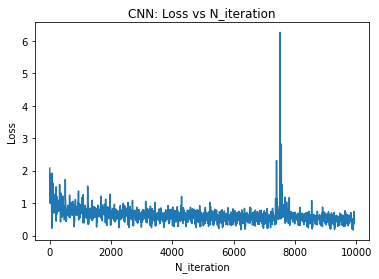

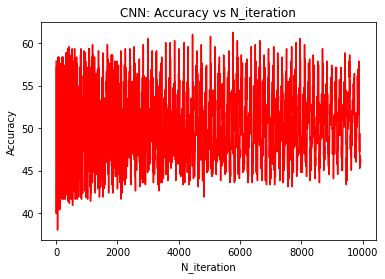

In [277]:
x_train = torch.from_numpy(train_x).type(torch.float32)
y_train = torch.from_numpy(train_y)
x_test = torch.from_numpy(test_x).type(torch.float32)
y_test = torch.from_numpy(test_y)

train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

#########Data Loader###########################3
batch_size = 16
n_iters = 10000
n_epochs = n_iters / (len(train_x) / batch_size)
n_epochs = int(n_epochs)

train_loader = DataLoader(train, batch_size = 16, shuffle = False)
test_loader = DataLoader(test, batch_size = 16, shuffle = False)

###################################

################################3
count = 0
loss_list = []
accuracy_list = []
iteration_list = []

for epoch in range(n_epochs):
    #for i, sent in enumerate(train_x):
    
    for i, (img, labels) in enumerate(train_loader):
        
        train = Variable(img)
        labels = Variable(labels)
        optimizer.zero_grad()
        outputs = model(train)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        count += 1

        if count % 5 == 0:
            correct = 0
            total = 0
            
            for i, (sent, label) in enumerate(test_loader):
           #for images, labels in test_loader:
                test = Variable(sent)
                label = Variable(label)
                output = model(test)
                predicted = torch.max(output.data, 1)[1]
                total += len(label)
                correct += (predicted == label).sum()
                
            accuracy = 100 * (correct / float(total))
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if count % 500 == 0:
            print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data, accuracy))
      
    
    
plt.plot(iteration_list,loss_list)
plt.xlabel("N_iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs N_iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("N_iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs N_iteration")
plt.show()


In [230]:
predicted = torch.max(outputs.data, 1)[1]

In [211]:
correct

tensor(175)

In [210]:
label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [221]:
test_y

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [222]:
test_y

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,